* 이 노트북은 test데이터로 모델을 refit한 경우입니다.
* pycaret은 제외했으며 이 외의 코드는 이전 자료와 유사합니다.
* refit은 학습 시간이 너무 오래걸리지 않도록, 매 시간 단위가 아닌 일주일마다 갱신하도록 했습니다.

In [ ]:
!pip install pandas
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install statsmodels
!pip install scikit-learn
!pip install pycaret
!pip install optuna

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import pandas as pd
import numpy as np
import datetime
from scipy import interpolate
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
import math
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
#from pycaret.regression import *
from prophet import Prophet
from neuralprophet import NeuralProphet
import lightgbm
import optuna

plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False

## 데이터 불러오기

In [2]:
# 학습 데이터
data_tr = pd.read_csv('./t1_data_city/data_tr_city.csv')
data_tr

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0
...,...,...
35058,2020-12-31 19:00:00,328.0
35059,2020-12-31 20:00:00,347.0
35060,2020-12-31 21:00:00,335.0
35061,2020-12-31 22:00:00,141.0


In [3]:
# 평가 데이터
data_ts = pd.read_csv('./t1_data_city/data_ts_city.csv')
data_ts

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2021-01-01 00:00:00,106.0
1,2021-01-01 01:00:00,184.0
2,2021-01-01 02:00:00,277.0
3,2021-01-01 03:00:00,197.0
4,2021-01-01 04:00:00,72.0
...,...,...
8419,2021-12-17 19:00:00,327.0
8420,2021-12-17 20:00:00,513.0
8421,2021-12-17 21:00:00,396.0
8422,2021-12-17 22:00:00,350.0


In [4]:
# 제출 양식
data_sample = pd.read_csv('./t1_data_city/sample_city.csv')
data_sample

,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 03:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8421,2021-12-17 21:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8422,2021-12-17 22:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8423,2021-12-17 23:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 컬럼명 변경

In [5]:
data_tr.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_ts.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_tr.head()

,datetime,적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0


### 결측치 확인

In [6]:
data_tr[data_tr.적산차.isnull()]

,datetime,적산차
1748,2017-03-14 21:00:00,NaN
1982,2017-03-24 15:00:00,NaN
12716,2018-06-14 21:00:00,NaN
12717,2018-06-14 22:00:00,NaN
13187,2018-07-04 12:00:00,NaN
13234,2018-07-06 11:00:00,NaN
27253,2020-02-10 14:00:00,NaN
27254,2020-02-10 15:00:00,NaN


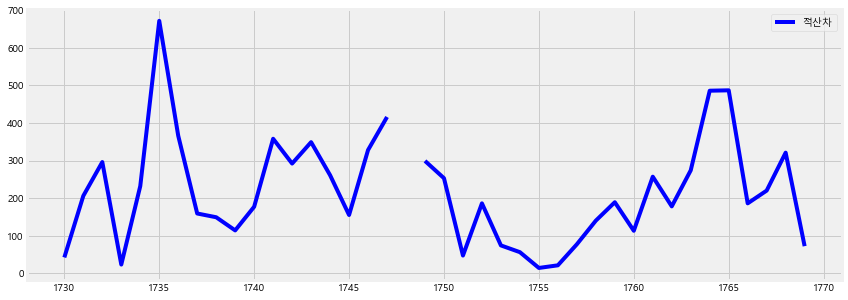

In [7]:
# 결측치 중 한 곳을 시각화
rcParams['figure.figsize'] = 13, 5
data_tr[1730:1770].plot(c='blue')
plt.show()

### 결측치 보간

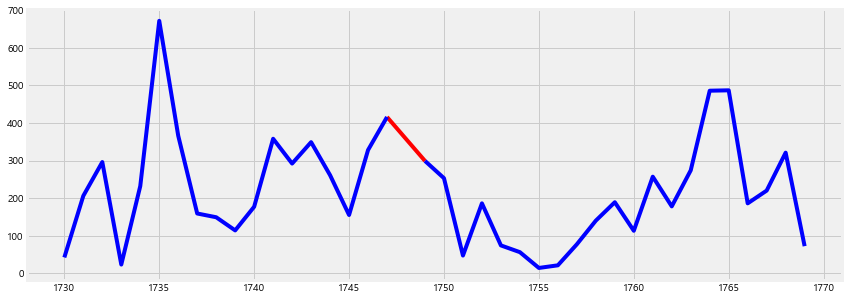

In [8]:
# linear 보간을 통해 결측치 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')

# 보간 후 데이터 시각화
data_tr_interpolate[1747:1750].적산차.plot(c='red')
data_tr[1730:1770].적산차.plot(c='blue')
plt.show()

data_tr = data_tr_interpolate

### 이상치 확인

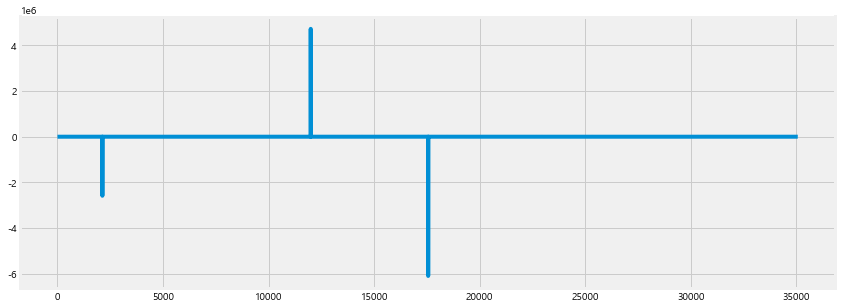

In [9]:
# 적산차가 비정상적으로 적거나 많게 표기된 행이 존재
rcParams['figure.figsize'] = 13, 5
data_tr.적산차.plot()
plt.show()

In [10]:
index = data_tr[data_tr.적산차 == max(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([11995], dtype='int64')


In [11]:
index = data_tr[data_tr.적산차 == min(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([17558], dtype='int64')


In [12]:
# 앞서 min(data_tr.적산차)인 행을 nan값으로 변경했으므로 그 다음 min값이 리턴된다.
index = data_tr[data_tr.적산차 == min(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([2127], dtype='int64')


#### 이상치 제거 결과

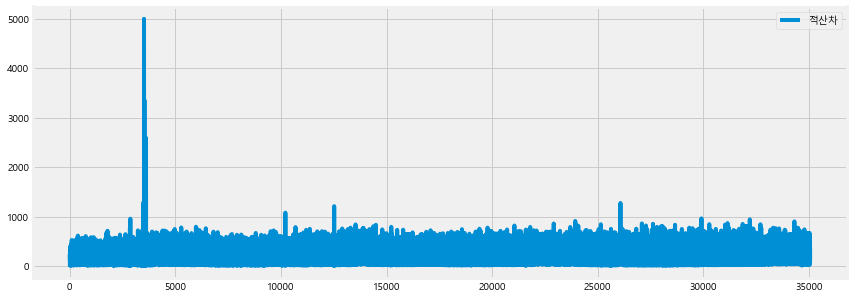

In [13]:
data_tr.plot()
plt.show()

In [14]:
# linear 보간을 통해 nan이 된 이상치를 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')
data_tr = data_tr_interpolate

In [15]:
# 시계열 분석을 위해 index를 datetime으로 변경
data_tr['datetime'] = pd.to_datetime(data_tr['datetime'])
data_tr.set_index('datetime', inplace=True)

data_ts['datetime'] = pd.to_datetime(data_ts['datetime'])
data_ts.set_index('datetime', inplace=True)

data_tr

,적산차
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0
...,...
2020-12-31 19:00:00,328.0
2020-12-31 20:00:00,347.0
2020-12-31 21:00:00,335.0


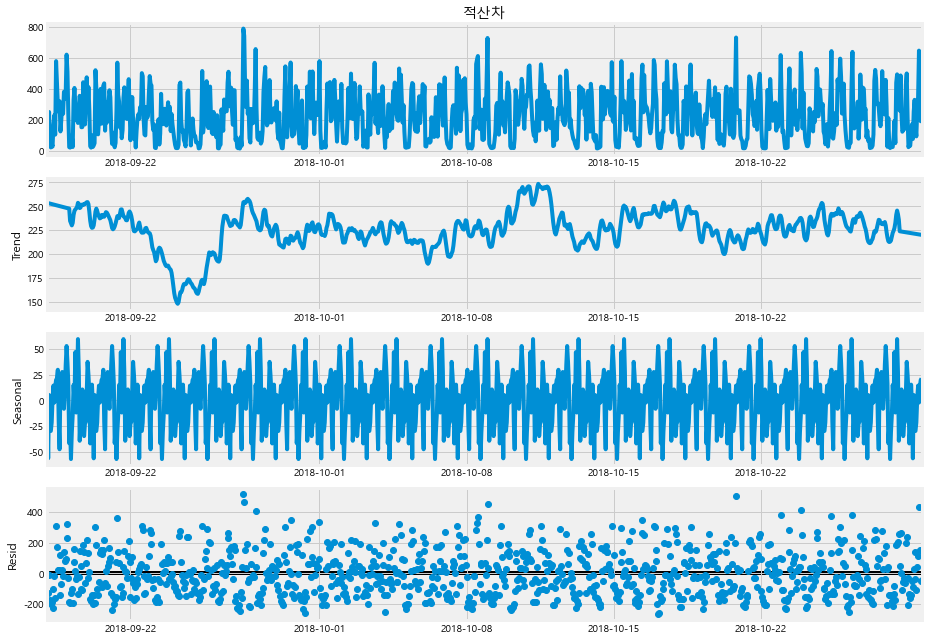

In [16]:
# 데이터가 시간단위이므로 너무 방대하여 가시성이 떨어진다.
rcParams['figure.figsize'] = 13, 9
decomposed_df_volume = sm.tsa.seasonal_decompose(data_tr['적산차'][15000:16000], extrapolate_trend='freq', period=52) # py3.6 이하는 freq=52 가능
figure = decomposed_df_volume.plot()
plt.show()

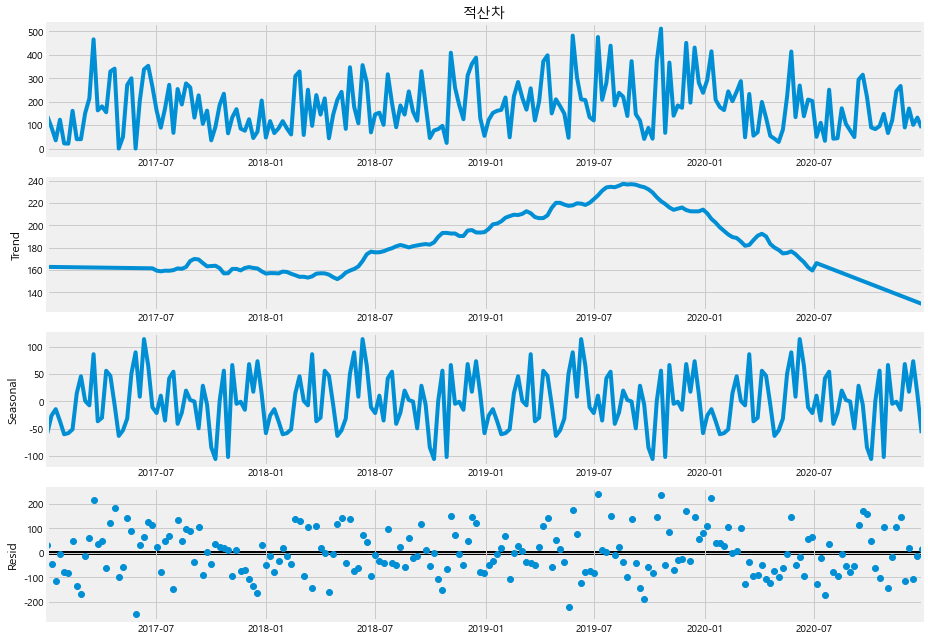

In [17]:
# asfreq('W')를 통해 일주일 단위로 묶어보니 한결 수월해졌다.
rcParams['figure.figsize'] = 13, 9
decomposed_df_volume = sm.tsa.seasonal_decompose(data_tr['적산차'].asfreq('W'), extrapolate_trend='freq', period=52) # py3.6 이하는 freq=52 가능
figure = decomposed_df_volume.plot()
plt.show()

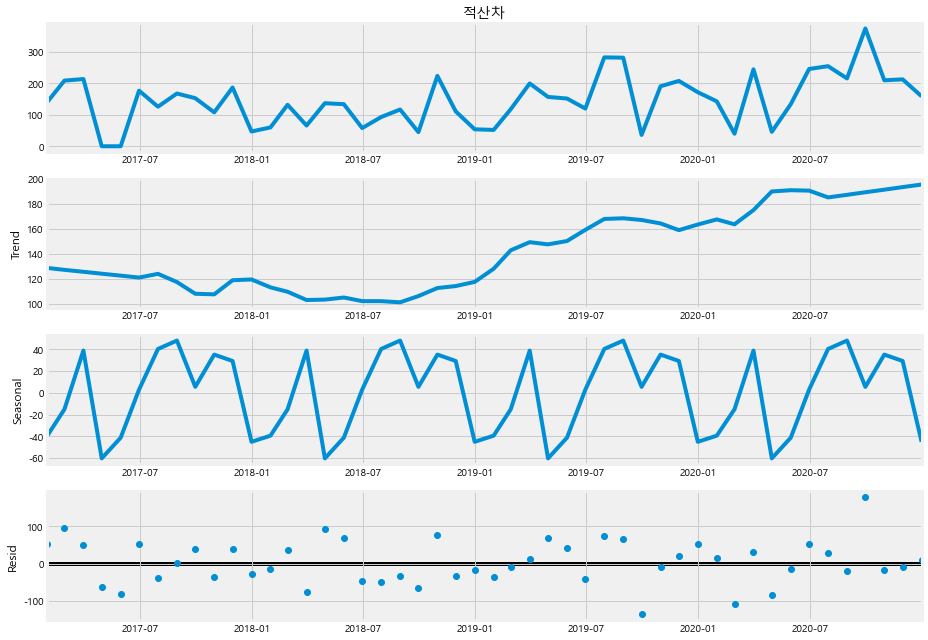

In [18]:
# 1달 단위로 변환하니 단순해졌다.
rcParams['figure.figsize'] = 13, 9
decomposed_df_volume = sm.tsa.seasonal_decompose(data_tr['적산차'].asfreq('M'), extrapolate_trend='freq') # py3.6 이하는 freq=52 가능
figure = decomposed_df_volume.plot()
plt.show()

* 계절성이 보인다고 해도, 1시간단위 데이터를 일주일, 월별로 묶어 계절성을 논하고, 이를 통해 각 시간을 예측하는 것은 굉장히 어렵다.

100%|██████████| 24/24 [00:06<00:00,  3.77it/s]


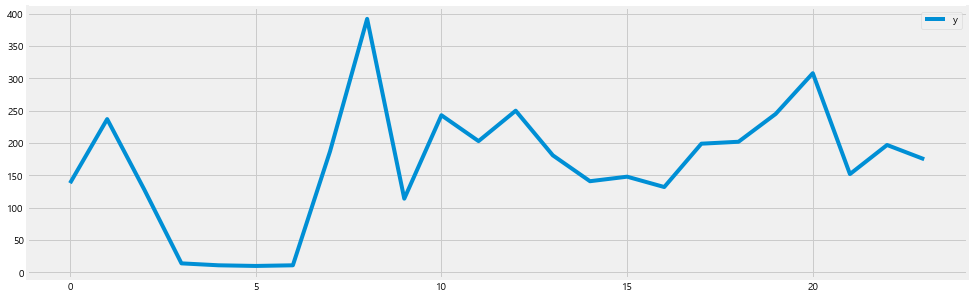

In [19]:
# 24시간에서 시간당 적산차의 평균.
# 아마 이 그래프에 트랜드와 백색소음, 기타 이벤트가 섞인 패턴이 반복될 것으로 예상된다.

meanperhour = []

for i in tqdm(range(24)):
    ytemp = []
    for j in range(len(data_tr)):
        hour = int(str(data_tr.index[j]).split()[1][:2])
        if i == j:
            ytemp.append(data_tr.적산차[i])
    meanperhour.append(np.mean(ytemp))

rcParams['figure.figsize'] = 15, 5
pd.DataFrame({'y':meanperhour}).plot()
plt.show()

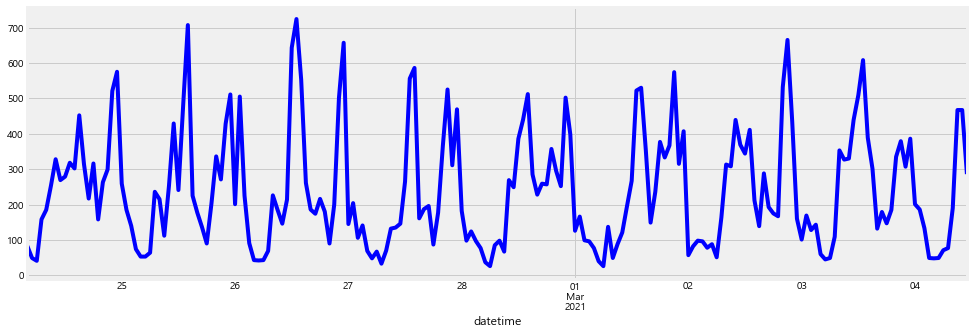

In [20]:
data_ts[1300:1500].적산차.plot(c='blue')
plt.show()

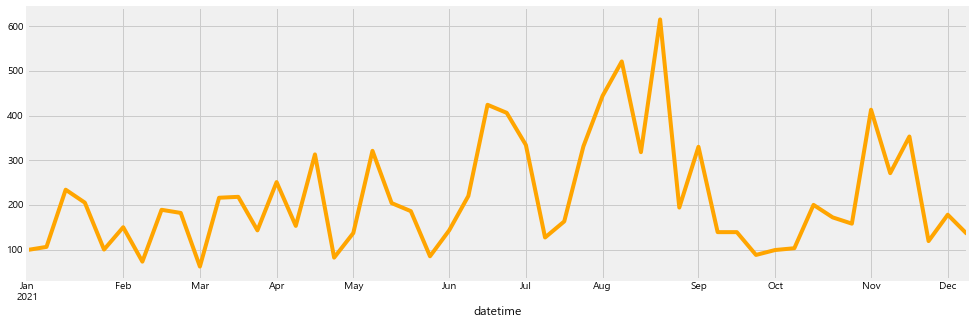

In [21]:
data_ts.asfreq('W').적산차.plot(c='orange')
plt.show()

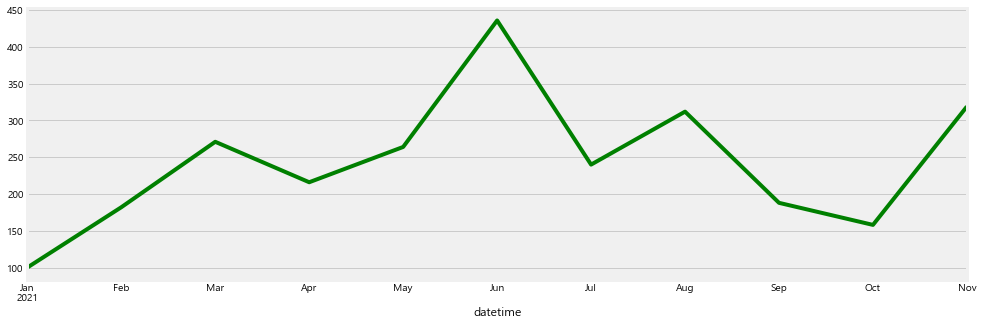

In [22]:
data_ts.asfreq('M').적산차.plot(c='green')
plt.show()

* 실제로 데이터 일부를 확인해보면, 24시간 패턴을 따르는 것을 알 수 있다. 즉, 일간 계절성이 보인다.
* 그러나 시간 단위 데이터에서는 월간, 년간 추세를 알아내기에는 데이터가 부족하다.

* 또한 현 분석의 목표는 단기간 예측이 아닌, 336 step을 예측해야하는 문제이다.
* 따라서 단기간 예측에 유리한 RNN, LSTM과 같은 모델보다는 중단기 예측에 유리한 Meta의 Prophet 모델을 통해 우선 예측을 해보았다.

### Prophet

In [101]:
data_tr_prophet = data_tr.copy()
data_tr_prophet.rename(columns= {'적산차':'y'}, inplace=True)
data_tr_prophet['ds'] = data_tr_prophet.index
data_tr_prophet.reset_index(drop=True, inplace=True)

data_ts_prophet = data_ts.copy()
data_ts_prophet.rename(columns= {'적산차':'y'}, inplace=True)
data_ts_prophet['ds'] = data_ts_prophet.index
data_ts_prophet.reset_index(drop=True, inplace=True)

In [47]:
mae_list = []
df = pd.concat([data_tr_prophet, data_ts_prophet], ignore_index=True)

for i in tqdm(range(len(data_sample))):
    
    if i%(24*7)==0:
        m= Prophet()
        m.fit(df[:len(data_tr_prophet)+i])

    forecast = m.predict(pd.DataFrame({'ds':data_sample.datetime[i:i+336]}))
    
    if i < 8000:
        mae_list.append(mean_absolute_error(data_ts['적산차'][i:i+336], forecast.yhat))
        clear_output()
        print(np.mean(mae_list))
        
    data_sample.loc[i] = [data_sample.datetime[i]] + list(forecast.yhat)
    
clear_output()
mae = np.mean(mae_list)
mae

  1%|          | 48/8425 [07:48<24:52:23, 10.69s/it]

97.70238971070495


04:26:19 - cmdstanpy - INFO - Chain [1] start processing
  1%|          | 48/8425 [08:00<23:17:45, 10.01s/it]

KeyboardInterrupt



In [ ]:
data_sample.to_csv('./submission/submission_prophet_live.csv', index=False)

### Neural Prophet

In [115]:
d = 24*7
mae_list = []
df = pd.concat([data_tr_prophet, data_ts_prophet], ignore_index=True)

for i in tqdm(range(len(data_sample))):
    if i%(24*7)==0:
        m = NeuralProphet(
            n_lags=d,
            n_forecasts=336,
            batch_size=64,
            epochs=75,
            )
        metrics = m.fit(df[:len(data_tr_prophet)+i], freq='H')
    
    start = pd.to_datetime(data_sample['datetime'][i])
    date_range = pd.date_range(start, start + datetime.timedelta(hours=335), freq='H')
    forecast_range = pd.DataFrame({'ds':date_range, 'y':np.NaN})
    forecast_range = pd.concat([df[len(data_tr_prophet)-d+i:len(data_tr_prophet)+i], forecast_range], ignore_index=True)
    
    forecast = m.predict(forecast_range)

    if i < 8000:
        result = [forecast['yhat'+str(j+1)][j+d] for j in range(336)]
        mae_list.append(mean_absolute_error(data_ts_prophet.y[i:i+336], result))
    clear_output()
    print(np.mean(mae_list))
    
    data_sample.loc[i] = [pd.to_datetime(data_sample.datetime[i])] + [forecast['yhat'+str(j+1)][d+j] for j in range(336)]
    
clear_output()    
mae = np.mean(mae_list)
mae

  0%|          | 0/5737 [00:00<?, ?it/s]INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.997% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


  0%|          | 0/164 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.61E-03, min: 2.54E-01


  0%|          | 0/164 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.61E-03, min: 2.24E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.81E-03

  0%|          | 0/5737 [00:25<?, ?it/s]

KeyboardInterrupt



In [ ]:
data_sample.to_csv('./submission/submission_neuralprophet_live.csv', index=False)

84.41687256691968


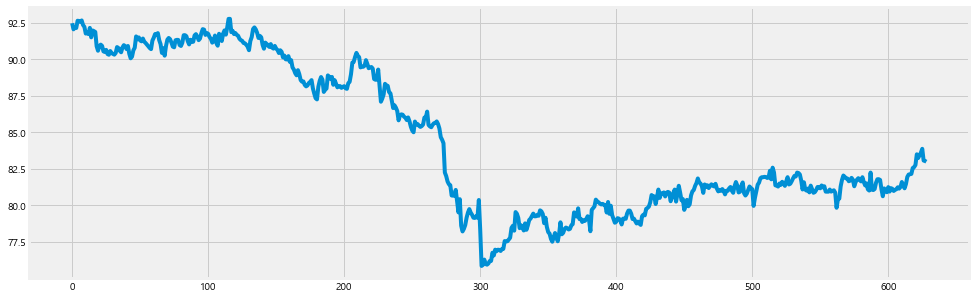

  7%|▋         | 629/8425 [31:25<1:08:02,  1.91it/s]INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.802% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


In [ ]:
d = 24*7
mae_list = []
df = pd.concat([data_tr_prophet, data_ts_prophet], ignore_index=True)

for i in tqdm(range(len(data_sample))):
    
    if i%(24*7)==0:
        m = NeuralProphet(
            n_lags=d,
            n_forecasts=336,
            batch_size=64,
            epochs=75,
            )
        metrics = m.fit(df[i:len(data_tr_prophet)+i], freq='H')
    
    start = pd.to_datetime(data_sample['datetime'][i])
    date_range = pd.date_range(start, start + datetime.timedelta(hours=335), freq='H')
    forecast_range = pd.DataFrame({'ds':date_range, 'y':np.NaN})
    forecast_range = pd.concat([df[len(data_tr_prophet)-d+i:len(data_tr_prophet)+i], forecast_range], ignore_index=True)
    
    forecast = m.predict(forecast_range)

    if i < 8000:
        result = [forecast['yhat'+str(j+1)][j+d] for j in range(336)]
        mae_list.append(mean_absolute_error(data_ts_prophet.y[i:i+336], result))
    clear_output()
    print(np.mean(mae_list))
    data_sample.loc[i] = [pd.to_datetime(data_sample.datetime[i])] + [forecast['yhat'+str(j+1)][d+j] for j in range(336)]
    plt.plot(mae_list)
    plt.show()
clear_output()    
mae = np.mean(mae_list)
mae

In [ ]:
data_sample.to_csv('./submission/submission_neuralprophet_live2.csv', index=False)

### LightGBM

In [116]:
# 기존에 정의했던 데이터셋을 활용하기 쉽게 재설계해준다.

train = data_tr.copy()
train.rename(columns= {'적산차':'y'}, inplace=True)
train['datetime'] = train.index
train.reset_index(drop=True, inplace=True)

train

,y,datetime
0,138.0,2017-01-01 01:00:00
1,237.0,2017-01-01 02:00:00
2,128.0,2017-01-01 03:00:00
3,14.0,2017-01-01 04:00:00
4,11.0,2017-01-01 05:00:00
...,...,...
35058,328.0,2020-12-31 19:00:00
35059,347.0,2020-12-31 20:00:00
35060,335.0,2020-12-31 21:00:00
35061,141.0,2020-12-31 22:00:00


#### 파생변수를 생성

In [117]:
def make_derived_variable(df):

    df['weekday'] = [d.weekday() for d in df.datetime] # 월=0, 화=1 ...
    df['month'] = df.datetime.dt.month
    df['hour'] = df.datetime.dt.hour
    df['year'] = df.datetime.dt.year
    
    return df

'''
def make_previous_y(df, p):
    
    for i in range(1, p+1):
        df['previous_y'+str(i)] = [np.NaN]*(i) + list(df.y[:-(i)])
    
    #df['previous_y'+str(i)] = [np.NaN] + list(df.y[:-1]) # 바로 직전 시간의 y를 변수로 생성
    
    return df
'''
def make_previous_y(df):
    
    df['previous_y'] = [np.NaN] + list(df.y[:-1]) # 바로 직전 시간의 y를 변수로 생성
    
    return df

#### train set

In [118]:
train = make_derived_variable(train)
train = make_previous_y(train)
train

,y,datetime,weekday,month,hour,year,previous_y
0,138.0,2017-01-01 01:00:00,6,1,1,2017,NaN
1,237.0,2017-01-01 02:00:00,6,1,2,2017,138.0
2,128.0,2017-01-01 03:00:00,6,1,3,2017,237.0
3,14.0,2017-01-01 04:00:00,6,1,4,2017,128.0
4,11.0,2017-01-01 05:00:00,6,1,5,2017,14.0
...,...,...,...,...,...,...,...
35058,328.0,2020-12-31 19:00:00,3,12,19,2020,305.0
35059,347.0,2020-12-31 20:00:00,3,12,20,2020,328.0
35060,335.0,2020-12-31 21:00:00,3,12,21,2020,347.0
35061,141.0,2020-12-31 22:00:00,3,12,22,2020,335.0


In [119]:
# previous_y[0] = NaN 인데, 이는 이전 시간의 데이터가 없기 떄문.
# train 데이터는 이전 데이터를 지니지 않았으므로 0번째 행은 제거하고 학습을 하도록 한다.
#train = train[p:].reset_index(drop=True)
#train.head()

#### 파생변수로 차분 추가

In [120]:
# 예측 시에는 자기자신의 실제 값을 모른다. 따라서 차분한 결과를 한 행씩 뒤에 배치한다.
def make_difference(df, d):
    
    for i in range(1, d+1):
        df['diff'+str(i)] = [np.NaN]*(i+1) + list(df.y.diff(i)[i:-1])

    return df

In [121]:
# train 이전의 데이터는 존재하지 않으므로, 차분 결과의 공란을 채울 방법이 없다. -> 채울 수 없는 데이터는 제거한다.
d = 5
train = make_difference(train, d)
train

,y,datetime,weekday,month,hour,year,previous_y,diff1,diff2,diff3,diff4,diff5
0,138.0,2017-01-01 01:00:00,6,1,1,2017,NaN,NaN,NaN,NaN,NaN,NaN
1,237.0,2017-01-01 02:00:00,6,1,2,2017,138.0,NaN,NaN,NaN,NaN,NaN
2,128.0,2017-01-01 03:00:00,6,1,3,2017,237.0,99.0,NaN,NaN,NaN,NaN
3,14.0,2017-01-01 04:00:00,6,1,4,2017,128.0,-109.0,-10.0,NaN,NaN,NaN
4,11.0,2017-01-01 05:00:00,6,1,5,2017,14.0,-114.0,-223.0,-124.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
35058,328.0,2020-12-31 19:00:00,3,12,19,2020,305.0,-168.0,51.0,101.0,-30.0,-42.0
35059,347.0,2020-12-31 20:00:00,3,12,20,2020,328.0,23.0,-145.0,74.0,124.0,-7.0
35060,335.0,2020-12-31 21:00:00,3,12,21,2020,347.0,19.0,42.0,-126.0,93.0,143.0
35061,141.0,2020-12-31 22:00:00,3,12,22,2020,335.0,-12.0,7.0,30.0,-138.0,81.0


In [122]:
train = train[d+1:]
train

,y,datetime,weekday,month,hour,year,previous_y,diff1,diff2,diff3,diff4,diff5
6,11.0,2017-01-01 07:00:00,6,1,7,2017,10.0,-1.0,-4.0,-118.0,-227.0,-128.0
7,187.0,2017-01-01 08:00:00,6,1,8,2017,11.0,1.0,0.0,-3.0,-117.0,-226.0
8,392.0,2017-01-01 09:00:00,6,1,9,2017,187.0,176.0,177.0,176.0,173.0,59.0
9,114.0,2017-01-01 10:00:00,6,1,10,2017,392.0,205.0,381.0,382.0,381.0,378.0
10,243.0,2017-01-01 11:00:00,6,1,11,2017,114.0,-278.0,-73.0,103.0,104.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35058,328.0,2020-12-31 19:00:00,3,12,19,2020,305.0,-168.0,51.0,101.0,-30.0,-42.0
35059,347.0,2020-12-31 20:00:00,3,12,20,2020,328.0,23.0,-145.0,74.0,124.0,-7.0
35060,335.0,2020-12-31 21:00:00,3,12,21,2020,347.0,19.0,42.0,-126.0,93.0,143.0
35061,141.0,2020-12-31 22:00:00,3,12,22,2020,335.0,-12.0,7.0,30.0,-138.0,81.0


#### test set

In [123]:
test = data_ts.copy()
test.rename(columns= {'적산차':'y'}, inplace=True)
test['datetime'] = test.index
test.reset_index(drop=True, inplace=True)

test

,y,datetime
0,106.0,2021-01-01 00:00:00
1,184.0,2021-01-01 01:00:00
2,277.0,2021-01-01 02:00:00
3,197.0,2021-01-01 03:00:00
4,72.0,2021-01-01 04:00:00
...,...,...
8419,327.0,2021-12-17 19:00:00
8420,513.0,2021-12-17 20:00:00
8421,396.0,2021-12-17 21:00:00
8422,350.0,2021-12-17 22:00:00


In [124]:
# test set은 train set을 활용해서 nan을 채울 수 있다.
test = pd.concat([train[-(d+1):], test])
test = make_derived_variable(test)
test = make_previous_y(test)
test = make_difference(test, d)
test.head(7)

,y,datetime,weekday,month,hour,year,previous_y,diff1,diff2,diff3,diff4,diff5
35057,305.0,2020-12-31 18:00:00,3,12,18,2020,NaN,NaN,NaN,NaN,NaN,NaN
35058,328.0,2020-12-31 19:00:00,3,12,19,2020,305.0,NaN,NaN,NaN,NaN,NaN
35059,347.0,2020-12-31 20:00:00,3,12,20,2020,328.0,23.0,NaN,NaN,NaN,NaN
35060,335.0,2020-12-31 21:00:00,3,12,21,2020,347.0,19.0,42.0,NaN,NaN,NaN
35061,141.0,2020-12-31 22:00:00,3,12,22,2020,335.0,-12.0,7.0,30.0,NaN,NaN
35062,112.0,2020-12-31 23:00:00,3,12,23,2020,141.0,-194.0,-206.0,-187.0,-164.0,NaN
0,106.0,2021-01-01 00:00:00,4,1,0,2021,112.0,-29.0,-223.0,-235.0,-216.0,-193.0


### Oputna

* 하이퍼 파라미터 탐색 AutoML

In [125]:
d = 5

tr = data_tr.copy()
tr.rename(columns= {'적산차':'y'}, inplace=True)
tr['datetime'] = tr.index
tr.reset_index(drop=True, inplace=True)

ts = data_ts.copy()
ts.rename(columns= {'적산차':'y'}, inplace=True)
ts['datetime'] = ts.index
ts.reset_index(drop=True, inplace=True)

df = pd.concat([tr[-(d+1):], ts], ignore_index=True)

start = pd.to_datetime(data_sample.datetime[8424])
date_range = pd.date_range(start, start + datetime.timedelta(hours=335), freq='H')
temp = pd.DataFrame({'datetime':date_range, 'y':np.NaN})
df = pd.concat([df, temp], ignore_index=True)

df = make_derived_variable(df)
df = make_previous_y(df)
df = make_difference(df, d)
df

,y,datetime,weekday,month,hour,year,previous_y,diff1,diff2,diff3,diff4,diff5
0,305.0,2020-12-31 18:00:00,3,12,18,2020,NaN,NaN,NaN,NaN,NaN,NaN
1,328.0,2020-12-31 19:00:00,3,12,19,2020,305.0,NaN,NaN,NaN,NaN,NaN
2,347.0,2020-12-31 20:00:00,3,12,20,2020,328.0,23.0,NaN,NaN,NaN,NaN
3,335.0,2020-12-31 21:00:00,3,12,21,2020,347.0,19.0,42.0,NaN,NaN,NaN
4,141.0,2020-12-31 22:00:00,3,12,22,2020,335.0,-12.0,7.0,30.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
8761,NaN,2021-12-31 19:00:00,4,12,19,2021,NaN,NaN,NaN,NaN,NaN,NaN
8762,NaN,2021-12-31 20:00:00,4,12,20,2021,NaN,NaN,NaN,NaN,NaN,NaN
8763,NaN,2021-12-31 21:00:00,4,12,21,2021,NaN,NaN,NaN,NaN,NaN,NaN
8764,NaN,2021-12-31 22:00:00,4,12,22,2021,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
col_list = df.columns[2:]
X_train = train[train.columns[2:]]
y_train = train[train.columns[0]]
X_train

,weekday,month,hour,year,previous_y,diff1,diff2,diff3,diff4,diff5
6,6,1,7,2017,10.0,-1.0,-4.0,-118.0,-227.0,-128.0
7,6,1,8,2017,11.0,1.0,0.0,-3.0,-117.0,-226.0
8,6,1,9,2017,187.0,176.0,177.0,176.0,173.0,59.0
9,6,1,10,2017,392.0,205.0,381.0,382.0,381.0,378.0
10,6,1,11,2017,114.0,-278.0,-73.0,103.0,104.0,103.0
...,...,...,...,...,...,...,...,...,...,...
35058,3,12,19,2020,305.0,-168.0,51.0,101.0,-30.0,-42.0
35059,3,12,20,2020,328.0,23.0,-145.0,74.0,124.0,-7.0
35060,3,12,21,2020,347.0,19.0,42.0,-126.0,93.0,143.0
35061,3,12,22,2020,335.0,-12.0,7.0,30.0,-138.0,81.0


In [127]:
def lgbm_objective(trial):

    params = {
            "objective": "regression",
            #"eval_metric":'mlogloss',
            "n_jobs": 4,
            "max_depth": trial.suggest_int("max_depth", 4, 256),
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int("n_estimators", 100, 3000, step=100),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1), 
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

    model = lightgbm.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    df_c = df.copy()
    
    for i in range(336):
        pred = model.predict(df_c[col_list][d+1+i:d+337+i])
        df_c['yhat'+str(i+1)] = np.NaN
        df_c.loc[np.arange(d+1+i, d+337+i), 'yhat'+str(i+1)] = pred
        df_c.loc[np.arange(d+1+i, d+337+i), 'y'] = pred

        df_c = make_derived_variable(df_c)
        df_c = make_previous_y(df_c)
        df_c = make_difference(df_c, d)

    mae_list = []
    mae_list.append(mean_absolute_error(data_ts['적산차'][:336], [df_c['yhat'+str(j+1)][d+1+j] for j in range(336)]))
    mae = np.mean(mae_list)   

    return mae

In [128]:
# optuna 튜닝
study = optuna.create_study(direction='minimize')
study.optimize(lgbm_objective, n_trials=100, show_progress_bar=True) # n_jobs -> lgbm에서 미리 선택해서 필요X

print("Number of finished trials: ", len(study.trials))
print("Best trial:")

trial = study.best_trial

print("  mae : {}".format(trial.value))
print("  Best hyperparameters: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-06 18:30:17,669] A new study created in memory with name: no-name-216258ef-49b0-4af7-824c-4f753d07fc5f


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-12-06 18:30:43,450] Trial 0 finished with value: 108.3715178712686 and parameters: {'max_depth': 40, 'num_leaves': 68, 'learning_rate': 0.19988055749629044, 'n_estimators': 3000, 'colsample_bytree': 0.5376966596967416, 'colsample_bynode': 0.6133866666139169, 'reg_lambda': 0.059688694127579725, 'reg_alpha': 0.02432578181132728, 'min_child_weight': 10, 'min_child_samples': 74}. Best is trial 0 with value: 108.3715178712686.
[I 2022-12-06 18:31:50,839] Trial 1 finished with value: 105.12383490529221 and parameters: {'max_depth': 93, 'num_leaves': 977, 'learning_rate': 0.16810327526813912, 'n_estimators': 2200, 'colsample_bytree': 0.8777669510662092, 'colsample_bynode': 0.697458766391956, 'reg_lambda': 0.41823470641773, 'reg_alpha': 0.591057589932344, 'min_child_weight': 15, 'min_child_samples': 78}. Best is trial 1 with value: 105.12383490529221.
[I 2022-12-06 18:32:10,761] Trial 2 finished with value: 109.31228699402845 and parameters: {'max_depth': 136, 'num_leaves': 25, 'learni

[I 2022-12-06 18:38:20,367] Trial 19 finished with value: 89.64711942722907 and parameters: {'max_depth': 165, 'num_leaves': 15, 'learning_rate': 0.11269762762407015, 'n_estimators': 400, 'colsample_bytree': 0.5688616652750335, 'colsample_bynode': 0.563292611594405, 'reg_lambda': 0.18853294492234252, 'reg_alpha': 0.04754067371422331, 'min_child_weight': 12, 'min_child_samples': 87}. Best is trial 19 with value: 89.64711942722907.
[I 2022-12-06 18:38:36,901] Trial 20 finished with value: 94.0386455098123 and parameters: {'max_depth': 106, 'num_leaves': 16, 'learning_rate': 0.09774712448207606, 'n_estimators': 1700, 'colsample_bytree': 0.7034635547845511, 'colsample_bynode': 0.56495449666879, 'reg_lambda': 0.20021891798196922, 'reg_alpha': 0.04119902170271235, 'min_child_weight': 15, 'min_child_samples': 47}. Best is trial 19 with value: 89.64711942722907.
[I 2022-12-06 18:38:49,689] Trial 21 finished with value: 92.41843014706873 and parameters: {'max_depth': 172, 'num_leaves': 4, 'lear

[I 2022-12-06 18:43:20,810] Trial 38 finished with value: 92.26062410366671 and parameters: {'max_depth': 85, 'num_leaves': 9, 'learning_rate': 0.2260586957359988, 'n_estimators': 600, 'colsample_bytree': 0.5218996327471414, 'colsample_bynode': 0.6201203369293316, 'reg_lambda': 0.7090944741248666, 'reg_alpha': 0.1238807555303027, 'min_child_weight': 6, 'min_child_samples': 100}. Best is trial 19 with value: 89.64711942722907.
[I 2022-12-06 18:43:35,664] Trial 39 finished with value: 94.8864925998361 and parameters: {'max_depth': 30, 'num_leaves': 33, 'learning_rate': 0.15034415592615472, 'n_estimators': 900, 'colsample_bytree': 0.5701510474632776, 'colsample_bynode': 0.5818145996798272, 'reg_lambda': 0.11949666504731182, 'reg_alpha': 0.055995823097088525, 'min_child_weight': 14, 'min_child_samples': 82}. Best is trial 19 with value: 89.64711942722907.
[I 2022-12-06 18:43:50,499] Trial 40 finished with value: 91.55472352681912 and parameters: {'max_depth': 129, 'num_leaves': 5, 'learnin

[I 2022-12-06 18:48:44,154] Trial 57 finished with value: 93.53333911099661 and parameters: {'max_depth': 168, 'num_leaves': 4, 'learning_rate': 0.5329225446603729, 'n_estimators': 1600, 'colsample_bytree': 0.8693700264719255, 'colsample_bynode': 0.6839519677234913, 'reg_lambda': 0.07750312202814348, 'reg_alpha': 0.020767650434967665, 'min_child_weight': 4, 'min_child_samples': 35}. Best is trial 19 with value: 89.64711942722907.
[I 2022-12-06 18:49:01,223] Trial 58 finished with value: 89.38804475552693 and parameters: {'max_depth': 210, 'num_leaves': 3, 'learning_rate': 0.6347823483101673, 'n_estimators': 2900, 'colsample_bytree': 0.6632349146551574, 'colsample_bynode': 0.5259969084480834, 'reg_lambda': 0.047703787470714416, 'reg_alpha': 0.058966709937859435, 'min_child_weight': 2, 'min_child_samples': 14}. Best is trial 58 with value: 89.38804475552693.
[I 2022-12-06 18:49:17,719] Trial 59 finished with value: 103.08043862287464 and parameters: {'max_depth': 210, 'num_leaves': 5, 'l

[I 2022-12-06 18:53:56,651] Trial 76 finished with value: 95.41912800697594 and parameters: {'max_depth': 204, 'num_leaves': 20, 'learning_rate': 0.5614943570284148, 'n_estimators': 200, 'colsample_bytree': 0.6187973220308217, 'colsample_bynode': 0.582844379462841, 'reg_lambda': 0.21500542271183642, 'reg_alpha': 0.08948068446687647, 'min_child_weight': 3, 'min_child_samples': 93}. Best is trial 58 with value: 89.38804475552693.
[I 2022-12-06 18:54:14,775] Trial 77 finished with value: 119.75290663473928 and parameters: {'max_depth': 150, 'num_leaves': 32, 'learning_rate': 0.5031507680862788, 'n_estimators': 1900, 'colsample_bytree': 0.5541990692793939, 'colsample_bynode': 0.5159040973754889, 'reg_lambda': 0.36440423019091717, 'reg_alpha': 0.030339426540309588, 'min_child_weight': 15, 'min_child_samples': 85}. Best is trial 58 with value: 89.38804475552693.
[I 2022-12-06 18:54:39,684] Trial 78 finished with value: 97.85697223467949 and parameters: {'max_depth': 190, 'num_leaves': 319, '

[I 2022-12-06 18:59:25,757] Trial 95 finished with value: 92.11964163156294 and parameters: {'max_depth': 222, 'num_leaves': 3, 'learning_rate': 0.888599182802195, 'n_estimators': 2900, 'colsample_bytree': 0.6522552281584645, 'colsample_bynode': 0.5157763106800168, 'reg_lambda': 0.06608413963792993, 'reg_alpha': 0.018454259048794497, 'min_child_weight': 5, 'min_child_samples': 9}. Best is trial 58 with value: 89.38804475552693.
[I 2022-12-06 18:59:48,980] Trial 96 finished with value: 167.56992358226915 and parameters: {'max_depth': 217, 'num_leaves': 83, 'learning_rate': 0.7868980197125861, 'n_estimators': 3000, 'colsample_bytree': 0.6390052353124723, 'colsample_bynode': 0.5235249062422497, 'reg_lambda': 0.08959470890627891, 'reg_alpha': 0.03697726125477832, 'min_child_weight': 5, 'min_child_samples': 16}. Best is trial 58 with value: 89.38804475552693.
[I 2022-12-06 19:00:06,651] Trial 97 finished with value: 117.70951028279056 and parameters: {'max_depth': 209, 'num_leaves': 5, 'lea

In [132]:
study.best_params

{'max_depth': 210,
 'num_leaves': 3,
 'learning_rate': 0.6347823483101673,
 'n_estimators': 2900,
 'colsample_bytree': 0.6632349146551574,
 'colsample_bynode': 0.5259969084480834,
 'reg_lambda': 0.047703787470714416,
 'reg_alpha': 0.058966709937859435,
 'min_child_weight': 2,
 'min_child_samples': 14}

In [129]:
d = 5
mae_list = []

for i in tqdm(range(len(data_sample))):
    
    if i%(24*7) == 0:
        train = pd.concat([data_tr, data_ts[:i]], ignore_index=False)
        train.rename(columns= {'적산차':'y'}, inplace=True)
        train['datetime'] = train.index
        train.reset_index(drop=True, inplace=True)

        train = make_derived_variable(train)
        train = make_previous_y(train)
        train = make_difference(train, d)

        X_train = train[train.columns[2:]]
        y_train = train[train.columns[0]]

        model = lightgbm.LGBMRegressor(**study.best_params)
        model.fit(X_train, y_train)
    
    df_c = df.copy()
    
    for j in range(336):
        pred = model.predict(df[col_list][d+1+j:d+337+j])

        df_c['yhat'+str(j+1)] = np.NaN
        df_c.loc[np.arange(d+1+j, d+337+j), 'yhat'+str(j+1)] = pred
        df_c.loc[np.arange(d+1+j, d+337+j), 'y'] = pred

        df_c = make_derived_variable(df_c)
        df_c = make_previous_y(df_c)
        df_c = make_difference(df_c, d)
        
    result = [df_c['yhat'+str(j+1)][d+1+i+j] for j in range(336)]
    data_sample.loc[i] = [pd.to_datetime(data_sample.datetime[i])] + result
    
    if i < 8000:
        mae_list.append(mean_absolute_error(data_ts['적산차'][i:i+336], result))
        clear_output()
        print(np.mean(mae_list))

  0%|          | 23/8425 [03:40<22:20:30,  9.57s/it]

89.4758734221912


  0%|          | 23/8425 [03:49<23:16:34,  9.97s/it]

KeyboardInterrupt



In [40]:
data_sample.to_csv('./submission/optuna_lgbm_live.csv', index=False)

In [ ]:
d = 5
step = 24*7
mae_list = []

for i in tqdm(range(len(data_sample))):
    
    if i%(step) == 0:
        train = pd.concat([data_tr[i:], data_ts[:i]], ignore_index=False)
        train.rename(columns= {'적산차':'y'}, inplace=True)
        train['datetime'] = train.index
        train.reset_index(drop=True, inplace=True)

        train = make_derived_variable(train)
        train = make_previous_y(train)
        train = make_difference(train, d)

        X_train = train[train.columns[2:]]
        y_train = train[train.columns[0]]

        model = lightgbm.LGBMRegressor(**study.best_params)
        model.fit(X_train, y_train)
    
        df_c = df.copy()

        for j in range(336):
            pred = model.predict(df[col_list][d+1+j:d+step+1+j])

            df_c['yhat'+str(j+1)] = np.NaN
            df_c.loc[np.arange(d+1+j, d+step+1+j), 'yhat'+str(j+1)] = pred
            df_c.loc[np.arange(d+1+j, d+step+1+j), 'y'] = pred

            df_c = make_derived_variable(df_c)
            df_c = make_previous_y(df_c)
            df_c = make_difference(df_c, d)

        for k in range(step):
            result = [df_c['yhat'+str(j+1)][d+1+i+j+k] for j in range(336)]
            data_sample.loc[i+k] = [pd.to_datetime(data_sample.datetime[i+k])] + result

            if i < 8000:
                mae_list.append(mean_absolute_error(data_ts['적산차'][i:i+336], result))
                clear_output()
                print(np.mean(mae_list))